# This Notebook was intended for LED calibration

In [1]:
'''
Load Package and define global variables
'''

import uproot
print(uproot.__version__)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import re
import matplotlib.patches as patches

from numpy import concatenate

import sys
sys.path.append("../src/") # go to parent dir

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams.update({'font.size': 14})

DATA_DIR='/media/disk_a/BNLBOX/WbLS-DATA/raw_root/calibration/'
ADC_TO_MV=2000/(2**14-1)


5.0.3


In [5]:
"""
defined a list of LED runs
"""

labels = [7.65, 7.75]
file_list=[
    "led_optHV_5dB_7.75V_230420T1834.root",
    "led_optHV_5dB_7.65V_230420T1832.root",
]

In [6]:
"""
Open one of the files
Check out a few waveform before doing any analysis
"""

my_ch = ['adc_b1_ch10']
f = uproot.open('%s/%s' % (DATA_DIR, file_list[0]))
t=f['daq']
wf={}
for ch in my_ch:
    wf[ch]=t[ch].array(library='np')

i=100

adc_b1_ch10 14.078672644731107
adc_b1_ch10 14.078672644731107
adc_b1_ch10 12.861581296150952
adc_b1_ch10 13.09980319508656
adc_b1_ch10 6.762014770022319
adc_b1_ch10 8.530450969907745
adc_b1_ch10 6.4815573697607585
adc_b1_ch10 8.826726105980631
adc_b1_ch10 9.265002614003947
adc_b1_ch10 6.639735969901213
adc_b1_ch10 10.569997339167122
adc_b1_ch10 15.373089312171448


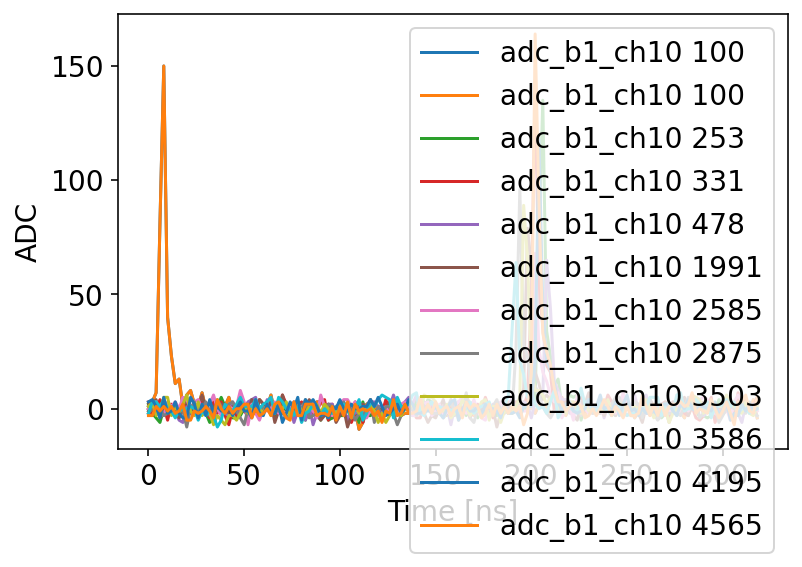

In [7]:
"""
A waveform that has a LED pulse interests me
"""
for j in range(100):
    for ch in my_ch:
        a=wf[ch][i]
        a = np.median(a)-a
        if np.max(a)>16:
            t = np.linspace(0, (len(a)-1)*2, len(a))
            plt.plot(t, a, label=ch+' %d' % i)
            print(ch, np.std(a))
            plt.grid()
            plt.xlabel('Time [ns]')
            plt.ylabel('ADC')
            plt.legend()
    i=i+j

In [8]:
"""
Load the data from the files
"""

event_id = {}
ch_id ={}
ch_names={} #active channel names
adc = {} # raw
for i, v in enumerate(labels):
    print('processing ', labels[i],'V')
    path = DATA_DIR + file_list[i]
    f = uproot.open(path)
    t = f['daq']
    event_id[v] =  t['event_id'].array(library='np')

    var_names = []
    ch_id[v] = []
    for ch_name in t.keys():
        if ch_name[0:4]=='adc_':
            var_names.append(ch_name)
            tmp = re.findall(r'\d+', ch_name)
            ch_id[v].append( int(tmp[0])*100+int(tmp[1]) )
    ch_names[v] = var_names
    adc[v] =  t.arrays(var_names, library='np')

processing  7.65 V
processing  7.75 V


In [9]:
"""
Define a map: ch_id -> ch_name
where ch_id is a int, and ch_name is a str
For example, 101 is adc_b1_ch1. 200 is adc_b2_ch0. 315 is adc_b3_ch15. You see the pattern?
"""
v=7.65
map_ch_name= dict(zip(ch_id[v], ch_names[v]))
print(map_ch_name)

{304: 'adc_b3_ch4', 108: 'adc_b1_ch8', 104: 'adc_b1_ch4', 107: 'adc_b1_ch7', 313: 'adc_b3_ch13', 411: 'adc_b4_ch11', 311: 'adc_b3_ch11', 208: 'adc_b2_ch8', 212: 'adc_b2_ch12', 406: 'adc_b4_ch6', 315: 'adc_b3_ch15', 403: 'adc_b4_ch3', 109: 'adc_b1_ch9', 201: 'adc_b2_ch1', 102: 'adc_b1_ch2', 210: 'adc_b2_ch10', 307: 'adc_b3_ch7', 308: 'adc_b3_ch8', 404: 'adc_b4_ch4', 204: 'adc_b2_ch4', 312: 'adc_b3_ch12', 101: 'adc_b1_ch1', 300: 'adc_b3_ch0', 402: 'adc_b4_ch2', 408: 'adc_b4_ch8', 205: 'adc_b2_ch5', 301: 'adc_b3_ch1', 203: 'adc_b2_ch3', 111: 'adc_b1_ch11', 207: 'adc_b2_ch7', 302: 'adc_b3_ch2', 112: 'adc_b1_ch12', 405: 'adc_b4_ch5', 103: 'adc_b1_ch3', 310: 'adc_b3_ch10', 200: 'adc_b2_ch0', 105: 'adc_b1_ch5', 110: 'adc_b1_ch10', 209: 'adc_b2_ch9', 106: 'adc_b1_ch6', 113: 'adc_b1_ch13', 303: 'adc_b3_ch3', 202: 'adc_b2_ch2', 214: 'adc_b2_ch14', 213: 'adc_b2_ch13', 206: 'adc_b2_ch6', 409: 'adc_b4_ch9', 400: 'adc_b4_ch0', 401: 'adc_b4_ch1', 309: 'adc_b3_ch9', 115: 'adc_b1_ch15', 407: 'adc_b4_ch

In [10]:
def calc_ch_vars(adc, chID, n_events=10000, roi_start_ns=264, roi_length=40, peak_cut=2):
    """
    This function calculate some variables at channel-level

    adc: list of array, shape=(n_ch, n_samples)
    ch: int or str. 
    n_events: int. 
    roi_length: int, but needs to be multiple of 2. ROI stands for region of interest.
    peak_cut: float. The minimal threshold in mV to qualify for a SPE pulse. 
    """
    if isinstance(chID, int):
        ch = map_ch_name[chID]
    if isinstance(chID, str):
        ch=chID

    if roi_start_ns<0:
        roi_start_ns=0
    roi_end = roi_start_ns + roi_length
    adc_ch = adc[ch]
    max_n_events = len(adc_ch)
    n_samples = len(adc_ch[0])
    if n_events<=0:
        n_events=max_n_events
        
    pT_ns = np.zeros(n_events)
    peak_mV = np.zeros(n_events)
    led_H = np.zeros(n_events)
    led_C= np.zeros(n_events)
    for i in range(n_events):
        if i>=max_n_events:
            n_events=max_n_events
            break
        amp = np.median(adc_ch[i]) - adc_ch[i] # inverted
        low_mV = np.min(amp)*ADC_TO_MV
        if low_mV>-2:
            peak = np.max(amp)
            peak_mV[i] = peak*ADC_TO_MV
            idx = np.argmax(np.median(adc_ch[i]) - adc_ch[i])
            pT_ns[i] = idx*2
        
            led_H[i] = np.max(amp[roi_start_ns//2:roi_end//2])*ADC_TO_MV
            led_C[i] = np.sum(amp[roi_start_ns//2:roi_end//2])*2*ADC_TO_MV/50
        
            freq_mask = (pT_ns>=roi_start_ns) & (pT_ns<roi_end) & (peak_mV >=peak_cut)
            freq =len(peak_mV[freq_mask])/n_events
    
    return dict(
        peak_time_ns=pT_ns,
        peak_mV=peak_mV,
        led_H=led_H,
        led_C=led_C,
        freq=freq,
    )

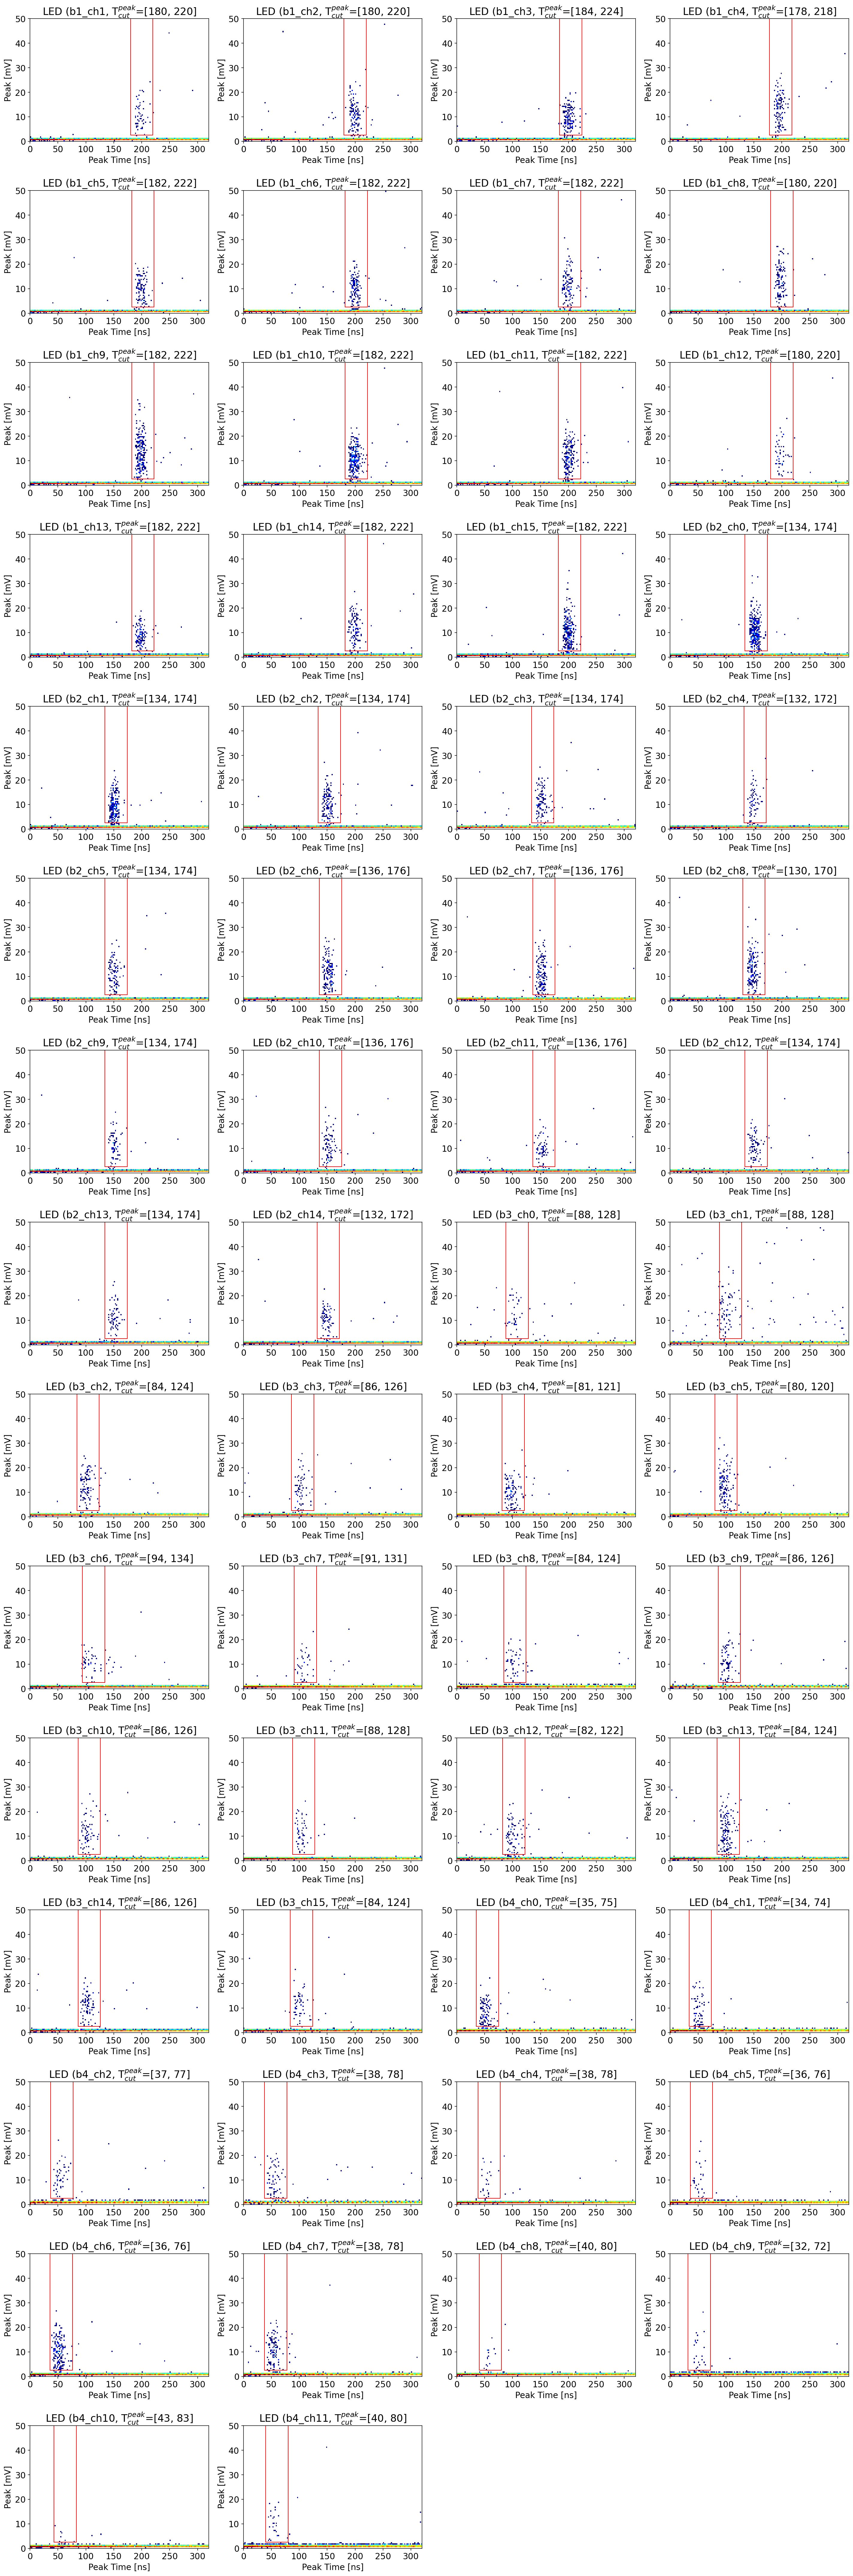

In [11]:

def find_peak_time(adc, ch_id, n_events=10000, roi_length=40, peak_cut=2):
    """    
    This function find peaks, and produce a plot of peak height vs peak time.
    
    adc: list of array, shape=(n_ch, n_samples)
    ch: str. one ch_name
    n_events: int. 
    roi_length: int, but needs to be multiple of 2. This is the width of the red box in plot.
    peak_cut: float. The minimal threshold in mV to qualify for a SPE pulse. This define the lower bound of the red box in plot. 
    """
    
    ch = map_ch_name[ch_id[0]]
    n_samples = len(adc[ch][0])
    n_ch = len(ch_id)
    ncols = 4
    nrows = int((n_ch-0.1)/ncols)+1
    plt.figure(figsize=[5*ncols,4*nrows])
    
    output={}
    for c, chID in enumerate(sorted(ch_id)):
        ch = map_ch_name[chID]
        rq = calc_ch_vars(adc, ch, n_events=10000, peak_cut=peak_cut)
        time_ns = rq['peak_time_ns']
        peak_mV = rq['peak_mV']
        
        ax = plt.subplot(nrows,ncols,c+1)
        xrange = (0, n_samples*2)
        yrange = [0, 50]
        plt.hist2d(time_ns, peak_mV, range=(xrange, yrange), bins=[n_samples, 100], 
                   norm=colors.LogNorm(), cmap='jet');
        
        # find proper roi window
        mask = peak_mV>=peak_cut
        if len(time_ns[mask])==0:
            roi_mid=100
        else:
            roi_mid = np.median(time_ns[mask])
        pre= roi_length//2-4
        roi_start_ns = roi_mid - pre
        output[chID]=int(roi_start_ns)
    
        rec_length=roi_length
        rect = patches.Rectangle((roi_start_ns, peak_cut), rec_length, yrange[1], 
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.title(r'LED (%s, T$^{peak}_{cut}$=[%d, %d]' % (ch[4:], roi_start_ns, roi_start_ns+roi_length))
        plt.xlabel('Peak Time [ns]')
        plt.ylabel('Peak [mV]')
    plt.tight_layout()
    plt.show()
    return output
    
v=7.75
pT_min = find_peak_time(adc[v], ch_id[v], n_events=10000, roi_length=40, peak_cut=2.5)


In [12]:
"""
Define ADC ch to PMT mapping
"""

chID2PMTMap = {
    # #bottom
    101: 'bt_p1', 102: 'bt_p2', 103: 'bt_p3', 104: 'bt_p4', 105: 'bt_p5', 106: 'bt_p6', 107: 'bt_p7', 108: 'bt_p8', 109: 'bt_p9', 110:'bt_p10', 
    111: 'bt_p11', 112:'bt_p12', 113:'bt_p13', 114:'bt_p14', 115:'bt_p15', 
    200: 'bt_p16',201: 'bt_p17',202: 'bt_p18',203: 'bt_p19',204: 'bt_p20', 
    205: 'bt_p21', 206: 'bt_p22', 207: 'bt_p23', 208: 'bt_p24',209: 'bt_p25', 210:'bt_p26',211:'bt_p27',212:'bt_p28',213:'bt_p29', 214:'bt_p30',
    
    #side b1-b4
    300: "b1_p1",301: "b1_p2",302: "b1_p3",303: "b1_p4",
    304: "b2_p1",305: "b2_p2",306: "b2_p3",307: "b2_p4",
    308: "b3_p1",309: "b3_p2",310:"b3_p3",311:"b3_p4",
    312:"b4_p1",313:"b4_p2", 314:"b4_p3", 315:"b4_p4",
    
    #side b5-b8
    400: "b5_p1",401: "b5_p2",402: "b5_p3",403: "b6_p1",404: "b6_p2",405: "b6_p3",
    406: "b7_p1",407: "b7_p2",408: "b7_p3",409: "b8_p1",410: "b8_p2",411: "b8_p3",
}

my_ch_id = chID2PMTMap.keys()
N_CHAN=len(my_ch_id)


In [13]:
%%time
"""
Calculate occupancy
This block may a while
"""
roi_length=40

freq = {}
for v in labels:
    freq[v]={}
    print('processing v=%.2f' % v)
    for i in sorted(ch_id[v]):
        rq = calc_ch_vars(adc[v], i, n_events=20000, 
                            roi_start_ns=pT_min[i], roi_length=roi_length, peak_cut=2)
        freq[v][i]=rq['freq']

good_intensity={} # which LED intensity to use for an channel
ch_out_of_range=[]
for i in my_ch_id:
    good_intensity[i] = 7.65
    ch_out_of_range.append(i)
    for v in sorted(labels):
        if freq[v][i]>=0.01 and freq[v][i]<0.05:
            print(i, '\t', freq[v][i], ' (v=%.2f)'%v, '\t (in range)')
            good_intensity[i] = v
            ch_out_of_range.remove(i)
            break

# manual adjustment
print("the following channel is out of range: ")
print(ch_out_of_range)

processing v=7.65
processing v=7.75
101 	 0.0275  (v=7.65) 	 (in range)
102 	 0.0117  (v=7.75) 	 (in range)
103 	 0.0134  (v=7.75) 	 (in range)
104 	 0.04435  (v=7.65) 	 (in range)
105 	 0.04755  (v=7.65) 	 (in range)
106 	 0.01215  (v=7.75) 	 (in range)
107 	 0.0119  (v=7.75) 	 (in range)
108 	 0.01075  (v=7.75) 	 (in range)
109 	 0.02365  (v=7.75) 	 (in range)
110 	 0.0265  (v=7.75) 	 (in range)
111 	 0.01695  (v=7.75) 	 (in range)
112 	 0.0265  (v=7.65) 	 (in range)
113 	 0.0116  (v=7.75) 	 (in range)
114 	 0.04765  (v=7.65) 	 (in range)
115 	 0.025  (v=7.75) 	 (in range)
200 	 0.0295  (v=7.75) 	 (in range)
201 	 0.0248  (v=7.75) 	 (in range)
202 	 0.0147  (v=7.75) 	 (in range)
203 	 0.04695  (v=7.65) 	 (in range)
204 	 0.02735  (v=7.65) 	 (in range)
205 	 0.0384  (v=7.65) 	 (in range)
206 	 0.01405  (v=7.75) 	 (in range)
207 	 0.01295  (v=7.75) 	 (in range)
208 	 0.0167  (v=7.75) 	 (in range)
209 	 0.0353  (v=7.65) 	 (in range)
210 	 0.0381  (v=7.65) 	 (in range)
211 	 0.0269  (v=7

In [14]:
good_intensity={} # which LED intensity to use for an channel
for i in my_ch_id:
    good_intensity[i] = 7.65

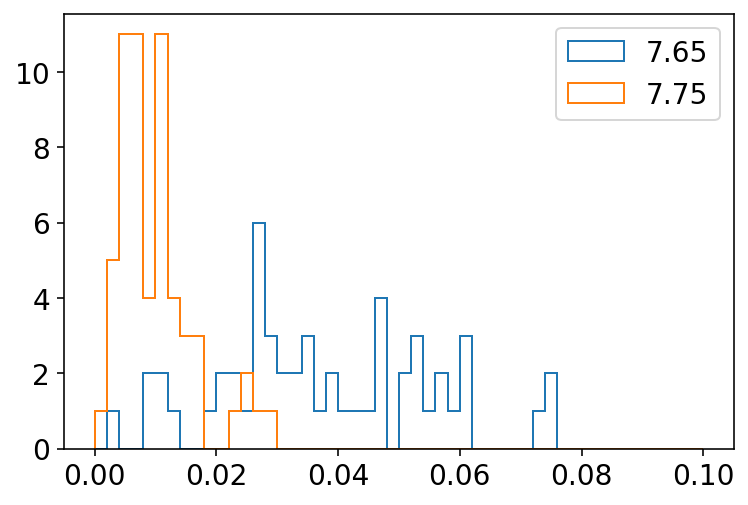

In [15]:

for v in labels:
    val = np.fromiter(freq[v].values(), dtype=float)
    plt.hist(val, bins=50, range=(0, 0.1), label=str(v), histtype='step')
plt.legend()
plt.show()



In [16]:
# where to decide if it's a SPE in peak height. unit: mV
SPE_PEAK_CUT=2

In [17]:
%%time
"""
Calcualte charge vs height
This block will take a while
"""

led_H={}
led_C={}
for i in my_ch_id:
    print('processing', i, '...' )
    v = good_intensity[i]
    rq = calc_ch_vars(adc[v], i, n_events=40000, 
                        roi_start_ns=pT_min[i], roi_length=40, peak_cut=SPE_PEAK_CUT)
    led_H[i] = rq['led_H']
    led_C[i] = rq['led_C']


processing 101 ...
processing 102 ...
processing 103 ...
processing 104 ...
processing 105 ...
processing 106 ...
processing 107 ...
processing 108 ...
processing 109 ...
processing 110 ...
processing 111 ...
processing 112 ...
processing 113 ...
processing 114 ...
processing 115 ...
processing 200 ...
processing 201 ...
processing 202 ...
processing 203 ...
processing 204 ...
processing 205 ...
processing 206 ...
processing 207 ...
processing 208 ...
processing 209 ...
processing 210 ...
processing 211 ...
processing 212 ...
processing 213 ...
processing 214 ...
processing 300 ...
processing 301 ...
processing 302 ...
processing 303 ...
processing 304 ...
processing 305 ...
processing 306 ...
processing 307 ...
processing 308 ...
processing 309 ...
processing 310 ...
processing 311 ...
processing 312 ...
processing 313 ...
processing 314 ...
processing 315 ...
processing 400 ...
processing 401 ...
processing 402 ...
processing 403 ...
processing 404 ...
processing 405 ...
processing 4

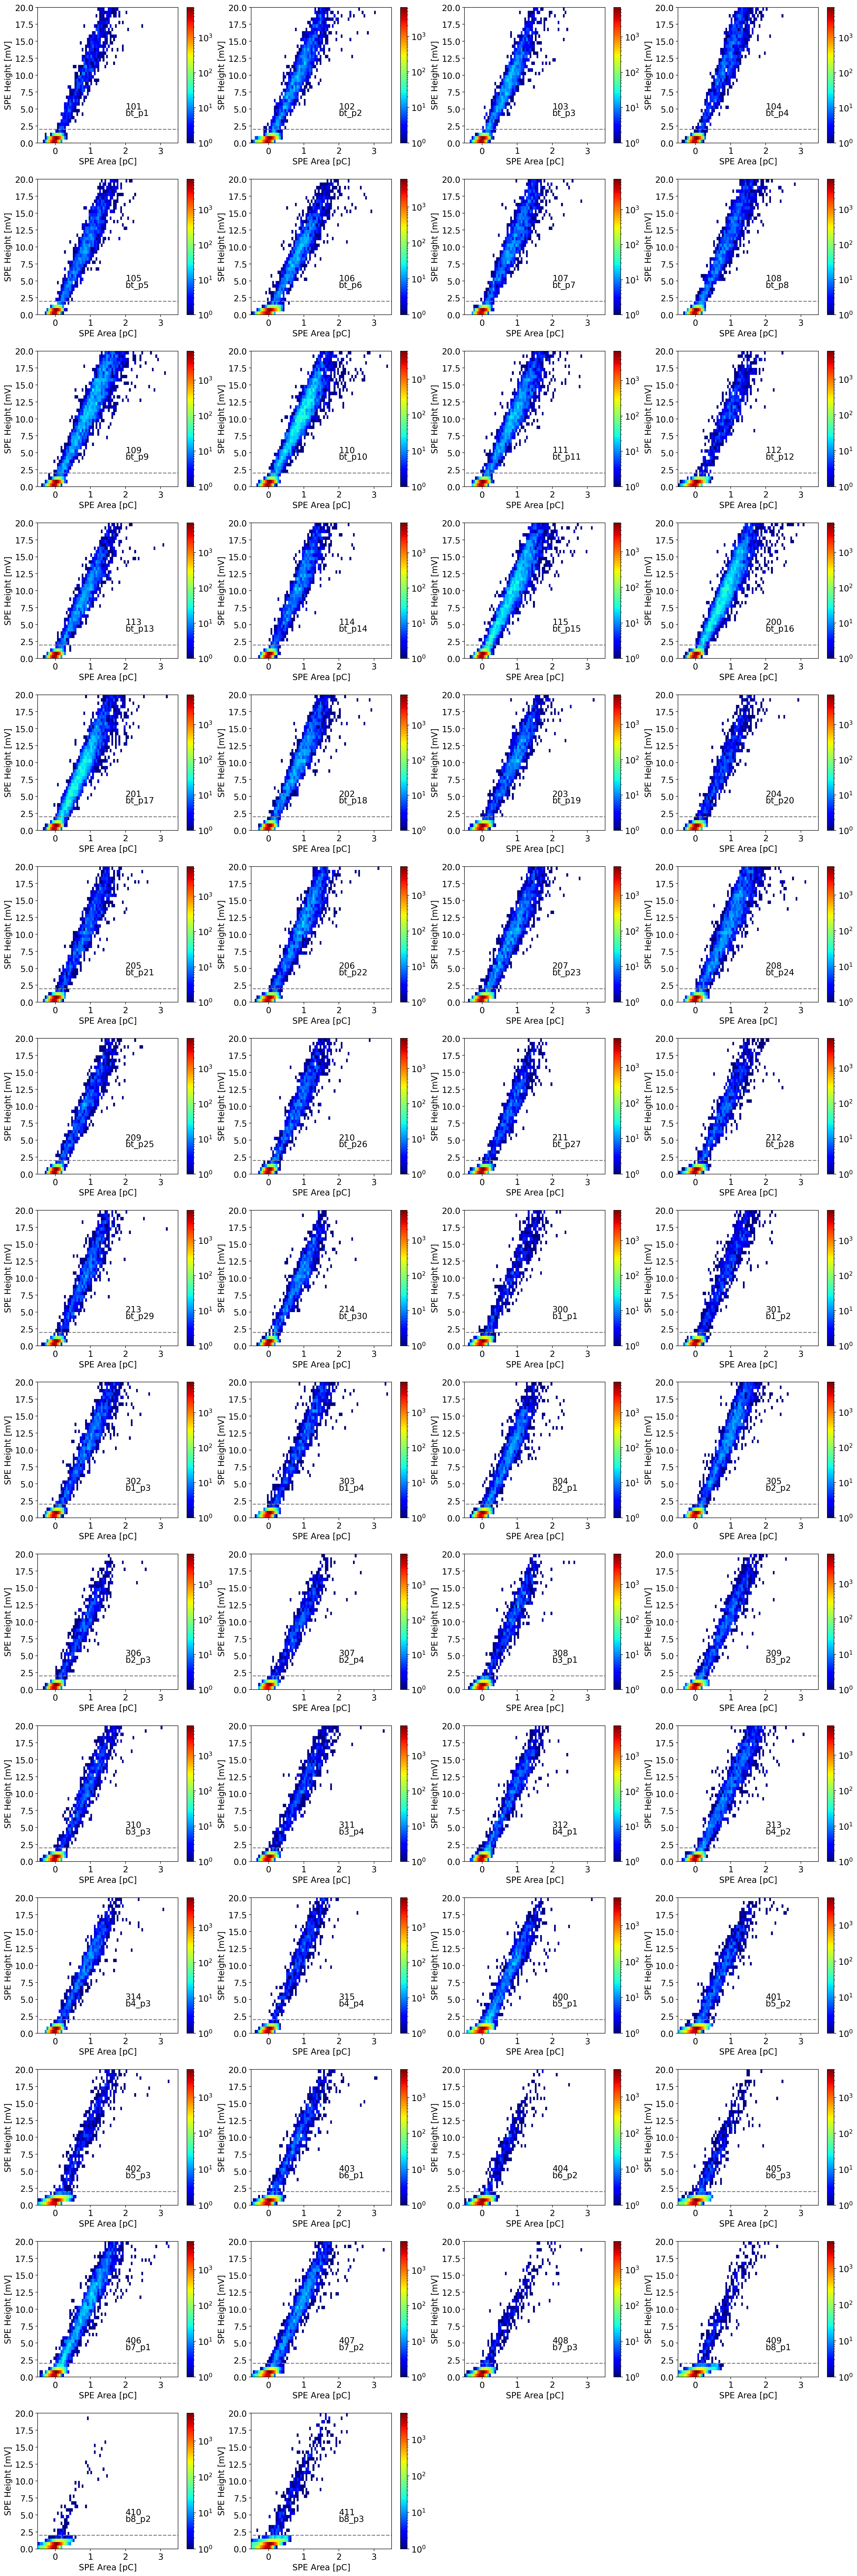

In [18]:
def plot_spe_AvsH():

    ncols = 4
    nrows = int((len(my_ch_id)-0.1)/ncols)+1
    plt.figure(figsize=[5*ncols,4*nrows], dpi=90)
    for c, i in enumerate(my_ch_id):
        ax = plt.subplot(nrows,ncols,c+1)

        C = led_C[i]
        H = led_H[i]
        h = plt.hist2d(C, H, bins=80, range=[[-0.5, 3.5],[0, 40]], 
                       cmap='jet', norm=colors.LogNorm());
        plt.hlines(SPE_PEAK_CUT, -1, 5, colors='grey', linestyle='dashed')
        plt.colorbar(h[3])
        plt.xlabel('SPE Area [pC]')
        plt.ylabel('SPE Height [mV]')
        plt.xlim(-0.5, 3.5)
        plt.ylim(0, 20)

        plt.text(2, 5, i)
        plt.text(2, 4, chID2PMTMap[i])

        # if i==406:
        #     for j in range(0, len(C)):
        #         if (H[j]>10) & (C[j]<0.3):
        #             print(j)
        #print("%dV, Occupancy: %.2f" % (v, occupancy))
plot_spe_AvsH()
plt.tight_layout()
plt.show()

In [19]:
from scipy.optimize import curve_fit

def gauss(x, mu, sigma, A):
    arg = (x-mu)/sigma
    N = A/np.sqrt(2*np.pi)/sigma
    return N*np.exp(-0.5*arg*arg)

def calc_chi2(func, xdata, ydata, popt):
    y = func(xdata, popt[0], popt[1], popt[2])
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

def chi2_fit(h, fit_range, p0=[1, 1, 1]):
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    tot = np.trapz(ydata[fit_mask], xdata[fit_mask])
    #tot = np.sum(ydata)
    p0[2]=tot
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = gauss(x, popt[0], popt[1], popt[2])
    
    chi2 = calc_chi2(gauss, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-2    
    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

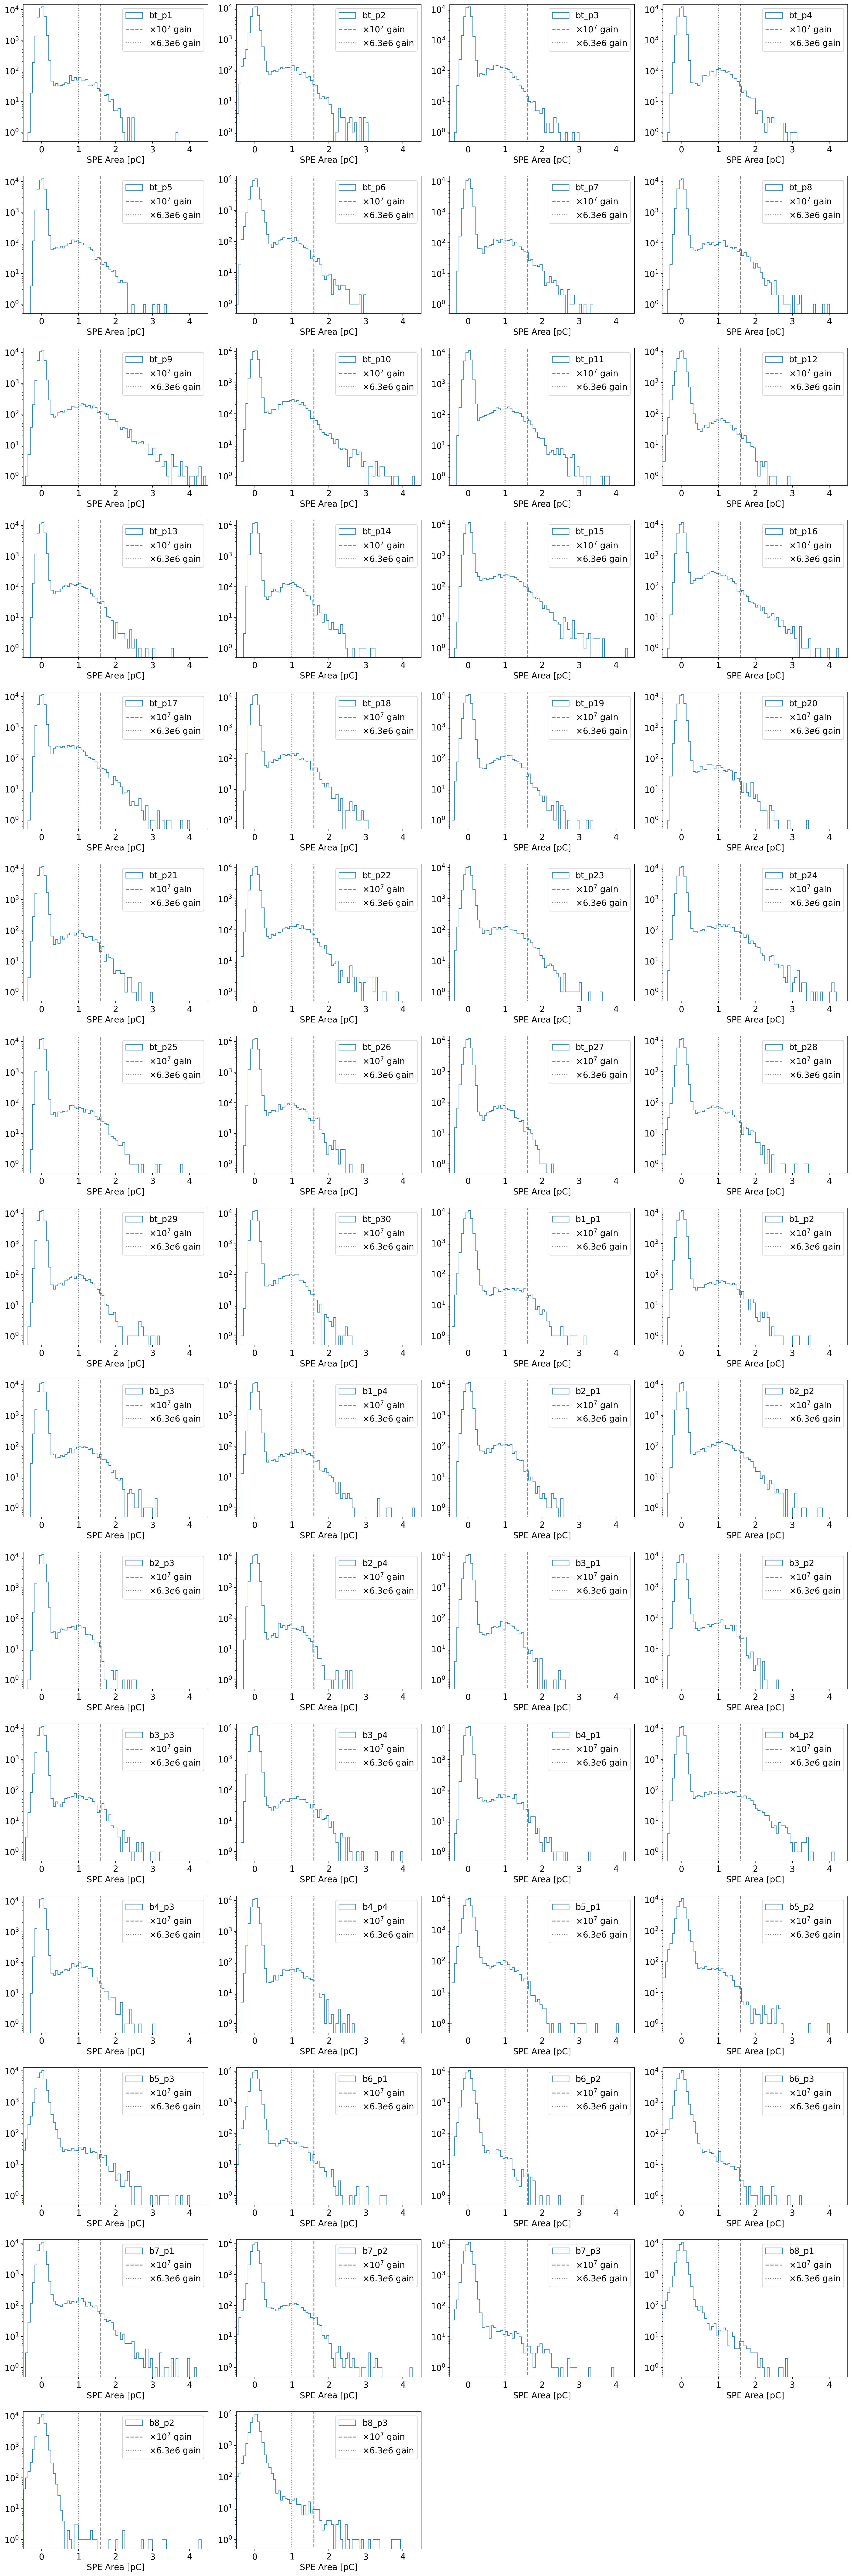

In [20]:
import pandas as pd
df = pd.DataFrame({
    'ch_id': [], 
    'ch_name': [],
    'pmt': [],
    'spe_mean': [],
    'spe_width': [],
    'chi2': [],
    'dof': [],
    'spe_mean_err': [],
    'spe_width_err': [],
    'HV': []
})


do_spe_fit=False
save_fit=False
appendix='230410T1100'
skipped_pmt=[]

# define fit range
fit_range={}
p0={}
for i in my_ch_id:
    pmt = chID2PMTMap[i]
    fit_range[pmt] = [0.55, 1.9]
    p0[pmt] = [1., 0.4, 1000]
fit_range['bt_p6'] = [0.6, 1.9]
fit_range['b2_p1'] = [0.5, 1.7]
fit_range['b4_p4'] = [0.5, 2]
fit_range['b6_p1'] = [0.8, 2.2]
fit_range['b8_p1'] = [0.8, 2]
fit_range['b8_p2'] = [0.8, 2]
fit_range['b8_p3'] = [0.8, 2]

def plot_spe_A(save_fig=True, appendix='220819b'):
    ncols = 4
    nrows = int((len(my_ch_id)-0.1)/ncols)+1
    plt.figure(figsize=[5*ncols,4*nrows], dpi=90)
    for c, i in enumerate(my_ch_id):
        ch=map_ch_name[i]
        ax = plt.subplot(nrows,ncols,c+1)
        C = led_C[i]
        H = led_H[i]
        mask=H>-SPE_PEAK_CUT
        # h = plt.hist(C[mask], bins=100, range=[-0.5, 6.5], histtype='step', 
        #              label='%s, %dV' % (ChName2PMTMap[ch], ChName2HVMap[ch]));
        pmt=chID2PMTMap[i]
        h = plt.hist(C[mask], bins=80, range=[-0.5, 4.5], histtype='step', 
                     label='%s' % (pmt));

        if do_spe_fit:
            if pmt in skipped_pmt:
                df.loc[len(df.index)]={
                    'ch_id': i, 
                    'ch_name': ch,
                    'pmt': pmt,
                    'spe_mean': 1.,
                    'spe_width': 0.5,
                    'chi2': -1,
                    'dof': -1,
                    'spe_mean_err': -1,
                    'spe_width_err': -1,
                    'HV': pmt
                }
            else:
                fit = chi2_fit(h, fit_range=fit_range[pmt], p0=p0[pmt])
                plt.plot(fit['x'], fit['y'], color='red')
                plt.text(2, 1e2, "chi2/dof=%.1f/%d" % (fit['chi2'],fit['dof'])  )
                df.loc[len(df.index)]={
                    'ch_id': i, 
                    'ch_name': ch,
                    'pmt': pmt,
                    'spe_mean': fit['popt'][0],
                    'spe_width': fit['popt'][1],
                    'chi2': fit['chi2'],
                    'dof': fit['dof'],
                    'spe_mean_err': fit['err'][0],
                    'spe_width_err': fit['err'][1],
                    'HV': pmt
                }
        
        plt.yscale('log')
        plt.xlabel('SPE Area [pC]')
        plt.xlim(-0.5, 4.5)
        plt.ylim(0.5, np.max(h[0]*1.2))
        plt.vlines(1.6, 0, 1e5, color='grey', linestyle='dashed', label=r'$\times 10^7$ gain')
        plt.vlines(1, 0, 1e5, color='grey', linestyle='dotted', label=r'$\times 6.3e6$ gain')
        plt.legend()
    plt.tight_layout()
    if save_fig:
        plt.savefig('bnl1t_spe_fit_results_%s.png' % appendix)
    plt.show()

plot_spe_A(save_fit, appendix)

In [ ]:
rchi2 = df['chi2']/df['dof']
plt.hist(rchi2, bins=40);
plt.xlabel('Reduced Chi2')
if save_fit:
    plt.savefig('rChi2_%s.png' % appendix)
plt.show()

In [ ]:
if save_fit:
    out_dir='/media/disk_a/BNLBOX/WbLS-DATA/db/spe/c'
    ofname = '%s/bnl1t_spe_fit_results_%s.csv' % (out_dir, appendix)
    df.to_csv(ofname, index=False)
    print('Info: output to', ofname)

# Monitor the Trend (plot multiple LED results)

In [ ]:
# data_dir='/media/disk_a/BNLBOX/WbLS-DATA/db/spe/c'
# file_list=[
#     "bnl1t_spe_fit_results_220819T1401.csv",
# ]
# file_paths = []
# for f in file_list:
#     file_paths.append(data_dir+'/'+f)


# colors = ['tab:blue', 'tab:orange', 'green', 'red', 'purple', 'blue', 'limegreen', 'magenta']
# legs = ['220819T1401', '220913T0000', '220919T1727', '220927T1001', '220930T1305', '221004T2355', '221011T1455', '221017T1414']

# fig = plt.figure(figsize=[12, 4], dpi=90)
# # ax1 = plt.subplot(211)
# # ax2 = plt.subplot(212, sharex = ax1)
# # make a little extra space between the subplots
# fig.subplots_adjust(hspace=0.5)
# #ax1.get_shared_x_axes().join(ax1, ax2)
# for i, f in enumerate(file_paths):
#     df = pd.read_csv(f)
#     pmt = df['pmt'].tolist() 
#     spe_mean = df['spe_mean'].to_numpy() 
#     spe_mean_err = df['spe_mean_err'].to_numpy() 
#     plt.errorbar(pmt, spe_mean, yerr=spe_mean_err, label=legs[i],
#                  color=colors[i], marker='.', linestyle="None")

# plt.xticks(rotation=90, fontsize=9)
# plt.ylabel('spe mean [pC]')
# plt.tight_layout()
# plt.legend(fontsize=12, loc='lower center')
# plt.show()

In [29]:
from datetime import datetime

def extract_date_from_str(s):
    """                                                                                                                                                                                                                       
    Extract date from a str. 
    The datetime must follow fixed format: YYmmddTHHMM                                                                                                                                                                                                               
    """
    import re
    match = re.search(r'\d{6}T\d{4}', s)
    try:
        dt = datetime.strptime(match.group(), '%y%m%dT%H%M')
        return dt.date() # only return the date
    except ValueError:
        print('Fail finding the datetime string from path: %s' % s)


file_paths = [
    "/media/disk_a/BNLBOX/WbLS-DATA/db/spe/c/bnl1t_spe_fit_results_230414T1621.csv",
]


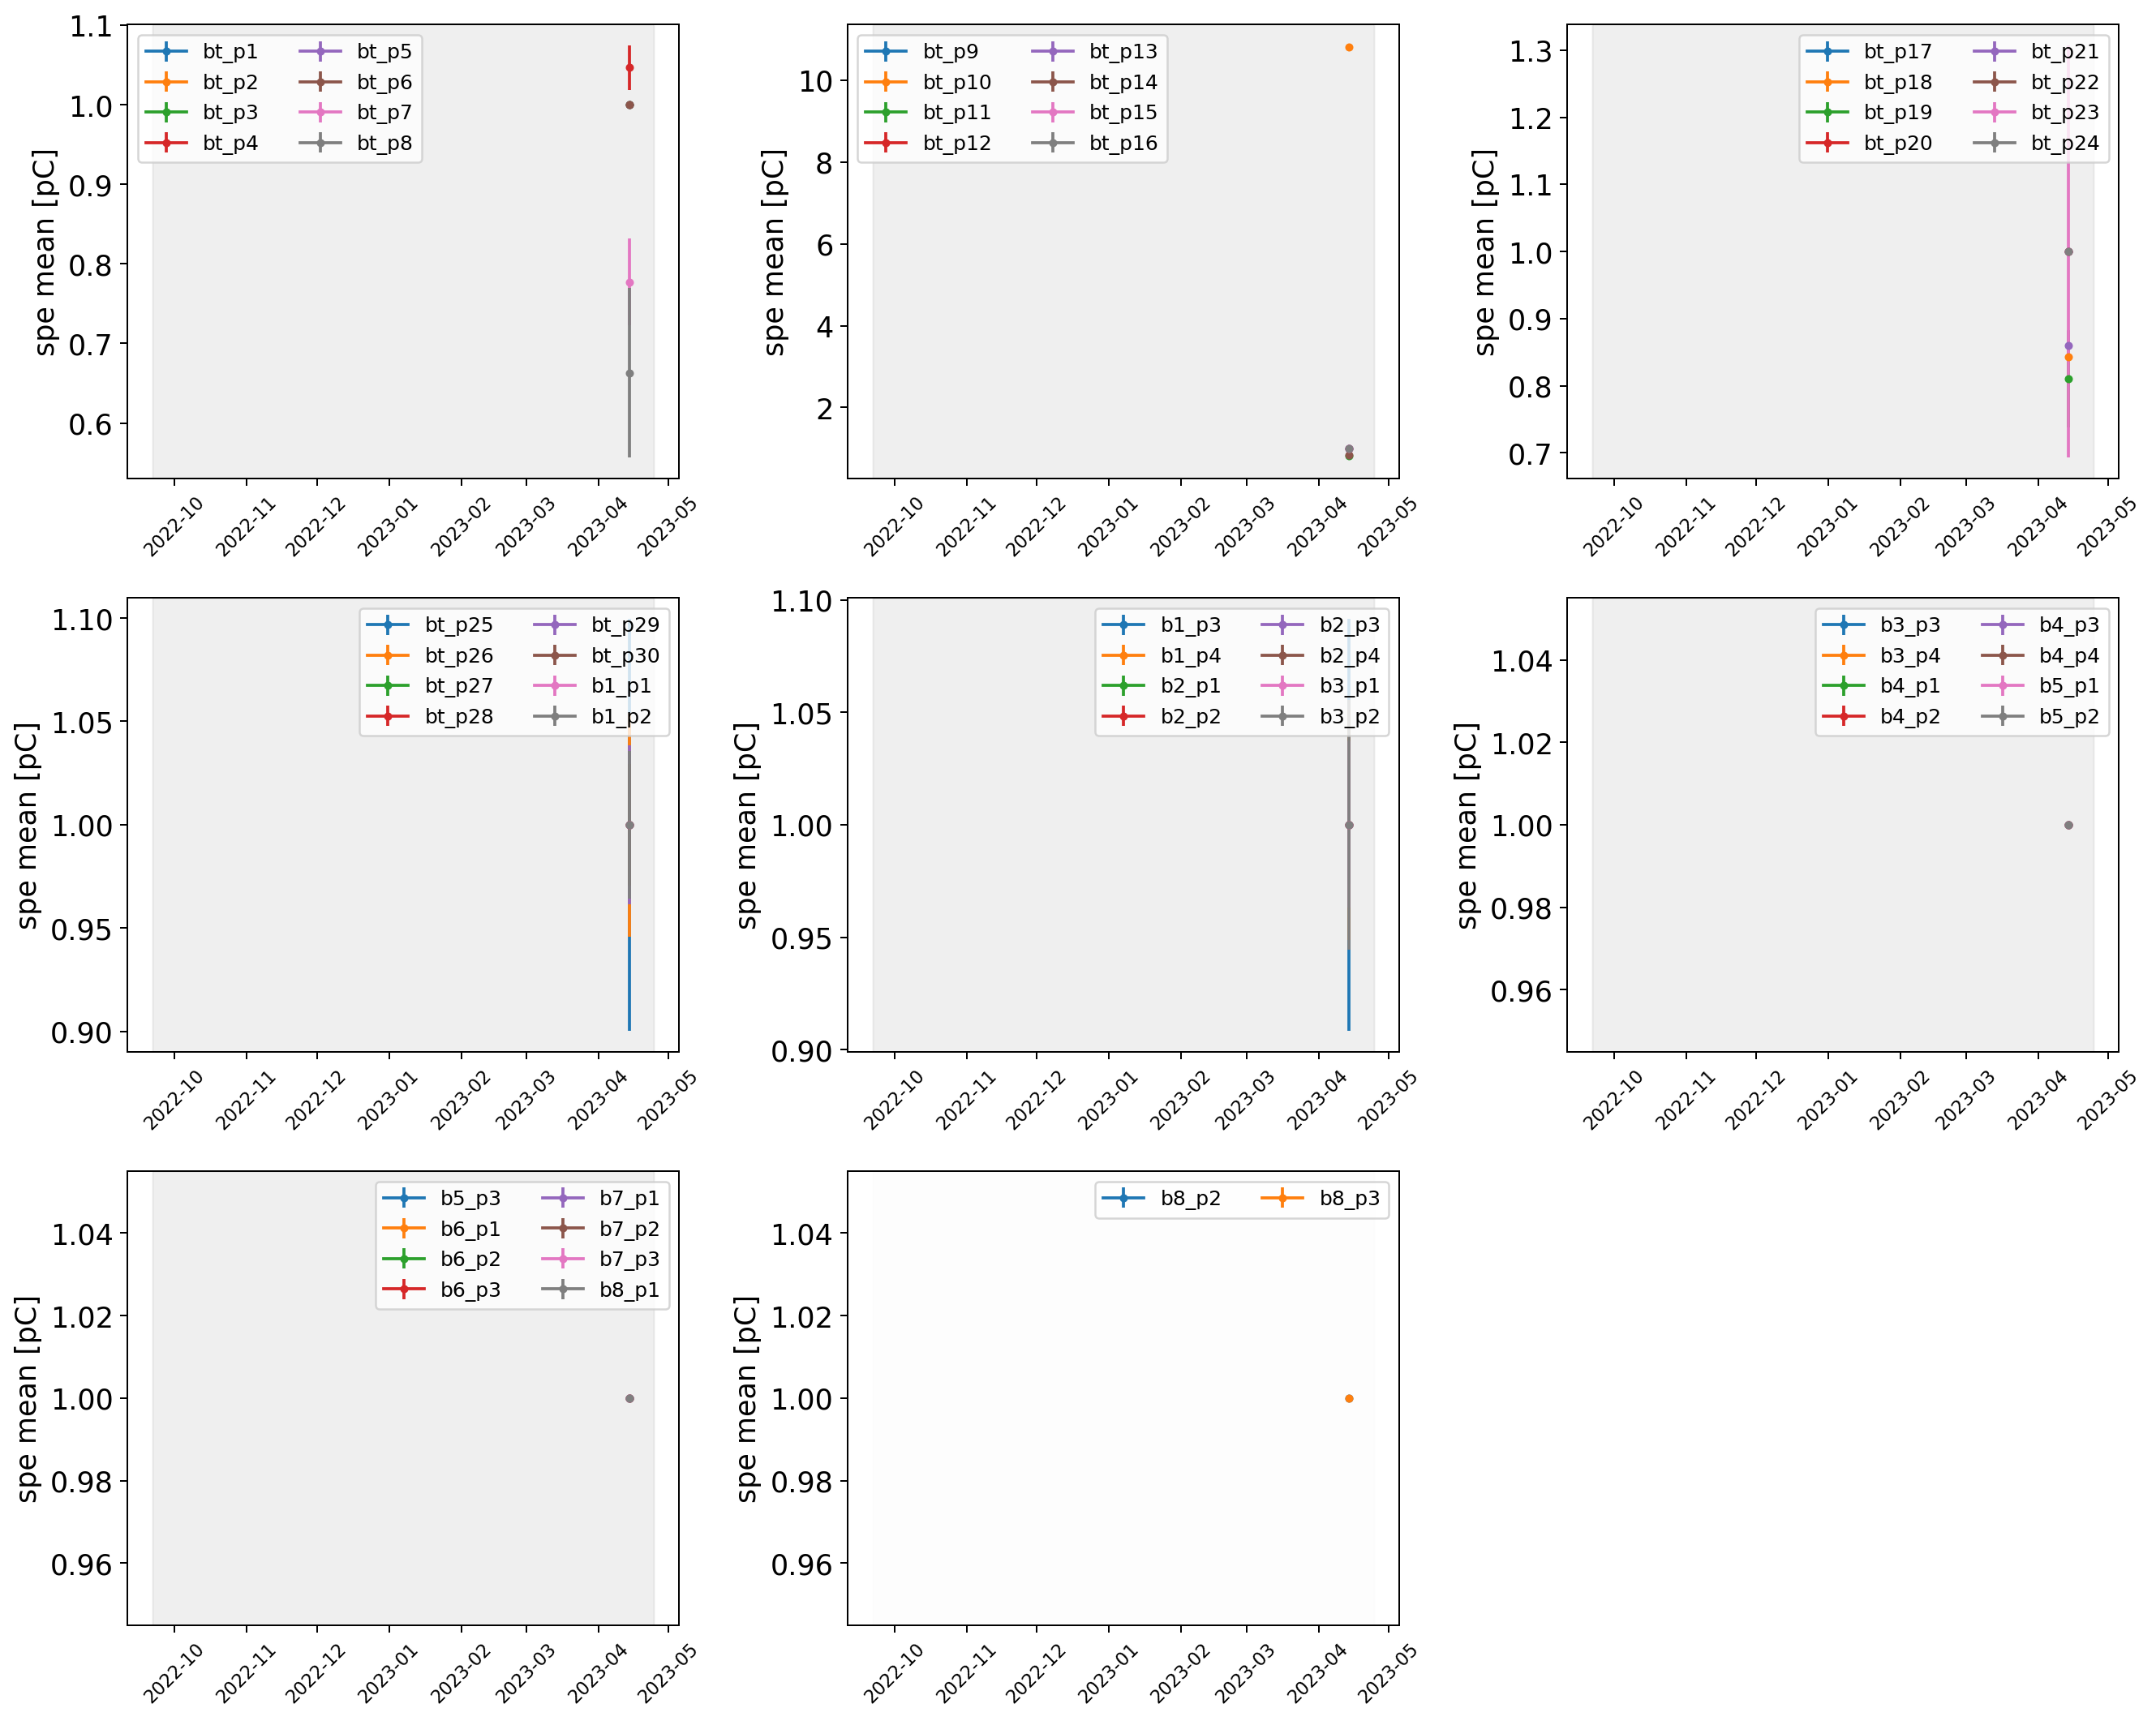

In [31]:
dt={}
spe_mean = {}
spe_mean_err = {}
for i, f in enumerate(file_paths):
    df = pd.read_csv(f)
    t=extract_date_from_str(f)
    pmt = df['pmt'].tolist() 
    mean = df['spe_mean'].to_numpy() 
    mean_err = df['spe_mean_err'].to_numpy()
    for j, p in enumerate(pmt):
        if p in skipped_pmt:
            continue
        if p in spe_mean.keys():
            dt[p].append( t )
            spe_mean[p].append( mean[j] )
            spe_mean_err[p].append( mean_err[j] )
        else:
            dt[p]= [ t ]
            spe_mean[p]= [ mean[j] ]
            spe_mean_err[p]= [ mean_err[j] ]


wbls_1pc_start= datetime.strptime('220921T1351', '%y%m%dT%H%M')
wbls_1pc_end = datetime.now()

ncols = 3
nrows = 3
plt.figure(figsize=[5*ncols,4*nrows], dpi=90)
for i, k in enumerate(dt.keys()):
    c = i // 8
    plt.axvspan(wbls_1pc_start, wbls_1pc_end, alpha=0.01, color='gray')
    ax = plt.subplot(nrows,ncols,c+1)
    plt.errorbar(dt[k], spe_mean[k], yerr=spe_mean_err[k], label=k, marker='.')
    plt.xticks(rotation=45, fontsize=9)
    plt.legend(fontsize=10, ncol=2)
    plt.ylabel('spe mean [pC]')
plt.tight_layout()
plt.show()